In [3]:
# Initialize the notebook
using Pkg
Pkg.activate("..")
#include("../src/Particles.jl")
using Particles
using Plots
using Zarr
using ZipFile

nothing

  Activating project at `~/src_nobackup/particles.jl.git_3dflow`


In [4]:
# unzip the test data

# function unzip(file,exdir="")
# extract all files from zip file to exdir
function unzip(file,exdir="")
    fileFullPath = isabspath(file) ?  file : joinpath(pwd(),file)
    basePath = dirname(fileFullPath)
    outPath = (exdir == "" ? basePath : (isabspath(exdir) ? exdir : joinpath(pwd(),exdir)))
    isdir(outPath) ? "" : mkdir(outPath)
    zarchive = ZipFile.Reader(fileFullPath)
    for f in zarchive.files
        fullFilePath = joinpath(outPath,f.name)
        if (endswith(f.name,"/") || endswith(f.name,"\\"))
            mkdir(fullFilePath)
        else
            write(fullFilePath, read(f))
        end
    end
    close(zarchive)
end

unzip("./data/locxxz_fullgrid_map.zip","./data")

In [2]:
using NetCDF
d=NetCDF.open("data/locxx_map.nc")
@show d.vars
z= d["mesh2d_layer_z"][:]
@show z' # z is a 1D array from -10 to 0
ts = d["time"][:] # d["time"].atts
@show ts' # ts is a 1D array with the time steps in seconds

d.vars = Dict{String, NcVar}("mesh2d_ucx" => Disk Array with size 40 x 400 x 21
, "mesh2d_taus" => Disk Array with size 400 x 21
, "mesh2d_edge_nodes" => Disk Array with size 2 x 1201
, "mesh2d_u0" => Disk Array with size 40 x 1201 x 21
, "mesh2d_Numlimdt" => Disk Array with size 400 x 21
, "mesh2d_tureps1" => Disk Array with size 41 x 1201 x 21
, "mesh2d_q1" => Disk Array with size 40 x 1201 x 21
, "mesh2d_interface_z" => Disk Array with size 41
, "mesh2d_edge_y" => Disk Array with size 1201
, "mesh2d_face_y" => Disk Array with size 400
, "mesh2d_edge_faces" => Disk Array with size 2 x 1201
, "projected_coordinate_system" => Disk Array with size 
, "mesh2d_u1" => Disk Array with size 40 x 1201 x 21
, "mesh2d_s0" => Disk Array with size 400 x 21
, "time" => Disk Array with size 21
, "mesh2d_face_x" => Disk Array with size 400
, "mesh2d_node_x" => Disk Array with size 802
, "mesh2d_face_x_bnd" => Disk Array with size 4 x 400
, "mesh2d_face_nodes" => Disk Array with size 4 x 400
, "mesh2

[-9.875 -9.625 -9.375 -9.125 -8.875 -8.625 -8.375 -8.125 -7.875 -7.625 -7.375 -7.125 -6.875 -6.625 -6.375 -6.125 -5.875 -5.625 -5.375 -5.125 -4.875 -4.625 -4.375 -4.125 -3.875 -3.625 -3.375 -3.125 -2.875 -2.625 -2.375 -2.125 -1.875 -1.625 -1.375 -1.125 -0.875 -0.625 -0.375 -0.125]
ts' = [0.0 30.00000000000005 59.99999999999979 89.9999999999995 119.99999999999922 149.99999999999997 180.0000000000011 210.00000000000225 240.00000000000338 270.0000000000045 300.0000000000056 330.00000000000676 360.0000000000079 390.00000000000904 420.0000000000102 450.0000000000113 480.00000000001245 510.0000000000136 540.0000000000094 570.0000000000049 600.0]


1×21 adjoint(::Vector{Float64}) with eltype Float64:
 0.0  30.0  60.0  90.0  120.0  150.0  …  480.0  510.0  540.0  570.0  600.0

In [34]:
# open the netcdf file with dflow.jl
dflow_map=load_nc_info("data",r"locxx_map.nc")
t0=get_reftime(dflow_map)
itime=10
u_velocity=load_nc_map_slice(dflow_map,"mesh2d_ucx",itime)
v_velocity=load_nc_map_slice(dflow_map,"mesh2d_ucy",itime)
times = get_times(dflow_map,t0)
@show times' # 0 to 600 seconds

nothing

[ Info: data/locxx_map.nc


times' = Any[0.0 30.00000000000005 59.99999999999979 89.9999999999995 119.99999999999922 149.99999999999997 180.0000000000011 210.00000000000225 240.00000000000338 270.0000000000045 300.0000000000056 330.00000000000676 360.0000000000079 390.00000000000904 420.0000000000102 450.0000000000113 480.00000000001245 510.0000000000136 540.0000000000094 570.0000000000049 600.0]


In [14]:
Zarr_data = ZarrData("./data","locxxz_fullgrid_map.zarr")
t0=get_reftime(Zarr_data)
h=initialize_interpolation(Zarr_data,"waterlevel",t0)
u=initialize_interpolation(Zarr_data,"x_velocity",t0)
s=initialize_interpolation(Zarr_data,"salinity",t0)

nothing

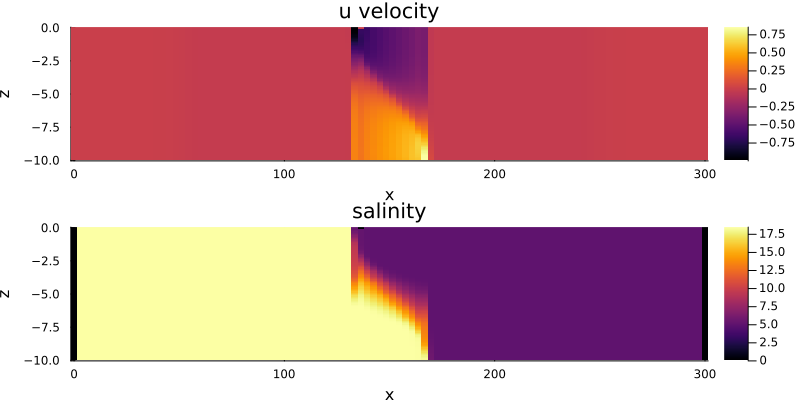

In [17]:
x_left = 0.0
x_middle = 150.0
x_right = 300.0
y_middle = 0.5
z_surface = 0.0
z_middle = -5.0
z_bottom = -10.0
t=40.0

# grid for plotting only
x_points = range(x_left,stop=x_right,length=100)
z_points = range(z_bottom,stop=z_surface,length=100)
u_interp = [u(x,y_middle,z,t) for x in x_points, z in z_points] # x velocity
s_interp = [s(x,y_middle,z,t) for x in x_points, z in z_points] # salinity

l = @layout([a; b])
p1=heatmap(x_points,z_points,u_interp',xlabel="x",ylabel="z",title="u velocity")
p2=heatmap(x_points,z_points,s_interp',xlabel="x",ylabel="z",title="salinity")
plot(p1,p2,layout=l,size=(800,400))